Summarize residual errors for an ARIMA model

In [37]:
# import libraries

from math import sqrt
import matplotlib.pyplot as plt 
plt.rcParams['figure.figsize'] = (12,8)
import numpy as np
import pandas as pd
import pickle
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima_model import ARIMA
import warnings

In [38]:
def load_prepare(df, arg_dict):
    """Load and prepare the data for train text split"""
    
    # load data
    series = df[arg_dict['dependent_variable']]
    
    # prepare data
    X = series.values
    X = X.astype('float32')
    
    return X


In [39]:
def train_test_spit(X, arg_dict):
    """Split into train and test"""
    
    train_size = int(len(X) * arg_dict['split_value'])
    train, test = X[0:train_size], X[train_size:]
    
    return train, test


In [40]:
def walk_forward_validation(train, test, arg_dict):
    """walk-forward validation"""

    history = [x for x in train]
    predictions = []
    bias = arg_dict['bias']
    for i in range(len(test)):

        # predict
        warnings.filterwarnings("ignore")
        model = ARIMA(history, order=arg_dict['best_cfg'])
        model_fit = model.fit(trend='nc', disp=0)
        yhat = bias + model_fit.forecast()[0]
        predictions.append(yhat)

        # observation
        obs = test[i]
        history.append(obs)
        
    return model_fit, predictions, history


In [41]:
def errors(test, predictions):
    """Calculate the errors that occurred between actual and predicted"""
    
    # report performance
    rmse = sqrt(mean_squared_error(test, predictions))
    print('RMSE: %.3f' % rmse)
    
    # calculate residual errors
    residuals = [test[i]-predictions[i] for i in range(len(test))]
    residuals = pd.DataFrame(residuals)
    print(residuals.describe())
    
    return residuals


In [42]:
def plot_residuals(residuals):
    """Plot the residuals (histogram and kde)"""
    
    plt.figure()
    plt.subplot(211)
    residuals.hist(ax=plt.gca())
    
    plt.subplot(212)
    residuals.plot(kind='kde', ax=plt.gca())
    plt.show();
    

In [43]:
def calc_bias(arg_dict, residuals):
    """Save the bias for a subsequent run"""
    
    # Get bias
    bias = residuals.describe()
    bias = bias.iloc[1][0]
    
    # Print appropriate message
    if arg_dict['bias'] == 0:
        arg_dict.update({'bias': bias})
        print('\nbias IS saved in arg_dict["bias"] for subsequent run is:', bias, '\n')
    else:
        print('\nbias NOT saved in arg_dict["bias"] for subsequent run is:', bias, '\n')
    

In [44]:
def driver(df, arg_dict):
    """Driver program"""

    # Get an array of the dependent variable values
    X = load_prepare(df, arg_dict)
    
    # Train test split (time series)
    train, test = train_test_spit(X, arg_dict)

    # walk-forward validation
    model_fit, predictions, history = walk_forward_validation(train, test, arg_dict)
    
    # Calculate the errors that occurred between actual and predicted
    residuals = errors(test, predictions)
    
    # plot the historgrams
    plot_residuals(residuals)
    
    # Save the bias for a subsequent run
    calc_bias(arg_dict, residuals)
    
    return model_fit, test, predictions


RMSE: 264.393
                  0
count  4.800000e+01
mean   8.715991e-13
std    2.671905e+02
min   -6.480247e+02
25%   -1.180788e+02
50%   -4.050938e+01
75%    1.161902e+02
max    7.888356e+02


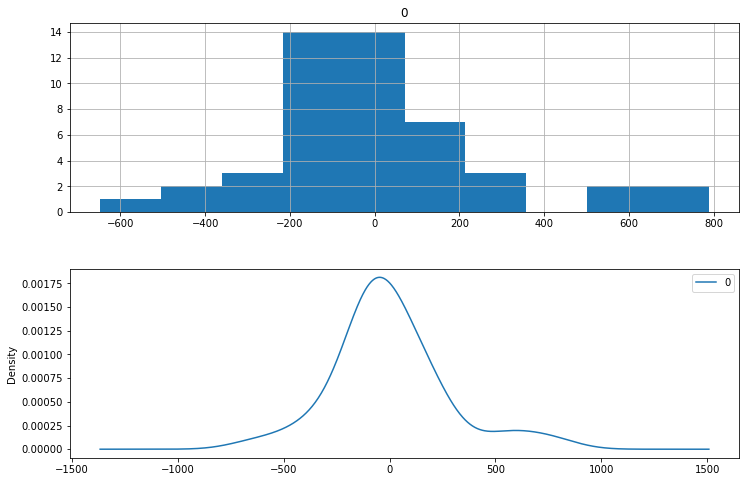


bias NOT saved in arg_dict["bias"] for subsequent run is: 8.715990891990563e-13 



In [45]:
if __name__ == '__main__':
    
    # Prepare arguments for driver
    with open('arg_dict.pickle', 'rb') as handle:
        arg_dict = pickle.load(handle)
    
    df = pd.read_csv('df.csv')
    
    # Start driver
    model_fit, test, predictions = driver(df, arg_dict) 
    